In [1]:
from keras.models import load_model

model = load_model('models/cats_and_dogs_small_2.h5')
model.summary()

Using TensorFlow backend.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 15, 15, 128)       147584    
__________

In [2]:
img_path = '/home/dhodun/data/test/cats/cat.1700.jpg'

from keras.preprocessing import image
import numpy as np

img = image.load_img(img_path, target_size=(150, 150))
img_tensor = image.img_to_array(img)
a = img_tensor
img_tensor = np.expand_dims(img_tensor, axis=0)
img_tensor /= 255.

print(img_tensor.shape)

(1, 150, 150, 3)


In [3]:
import matplotlib.pyplot as plt

plt.imshow(img_tensor[0])
plt.show()

In [4]:
from keras import models

layer_outputs = [layer.output for layer in model.layers[:8]]
activation_model = models.Model(inputs = model.input, outputs = layer_outputs)

In [5]:
activation_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9_input (InputLayer)  (None, 150, 150, 3)       0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 17, 17, 128)       0         
__________

In [6]:
activations = activation_model.predict(img_tensor)

Activation shape for layer 1:, (1, 148, 148, 32)
Activation shape for layer 2:, (1, 74, 74, 32)
Activation shape for layer 3:, (1, 72, 72, 64)
Activation shape for layer 4:, (1, 36, 36, 64)
Activation shape for layer 5:, (1, 34, 34, 128)
Activation shape for layer 6:, (1, 17, 17, 128)
Activation shape for layer 7:, (1, 15, 15, 128)
Activation shape for layer 8:, (1, 7, 7, 128)


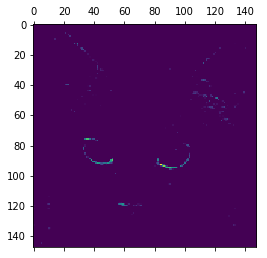

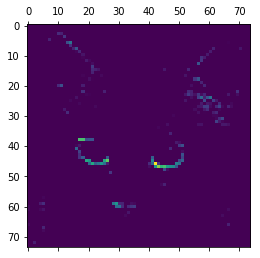

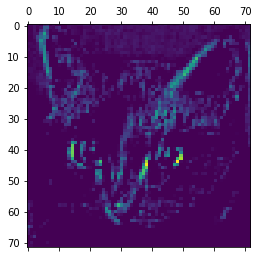

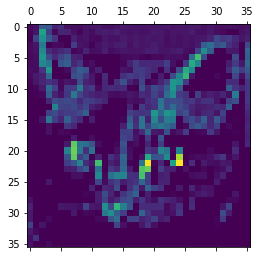

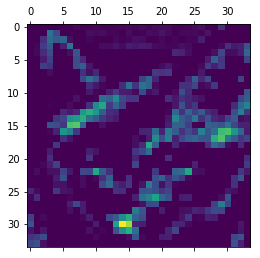

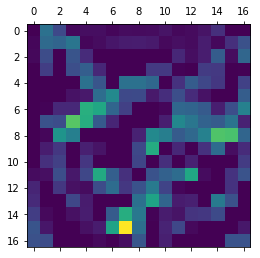

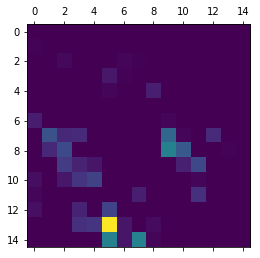

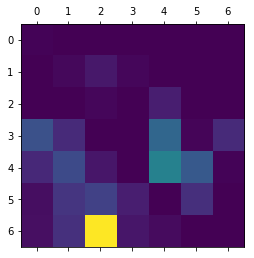

In [7]:
for i in range(8):
    print("Activation shape for layer {}:, {}".format( i+1, activations[i].shape))
    plt.matshow(activations[i][0, :, :, 4], cmap='viridis')

/home/dhodun/.local/lib/python2.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in divide


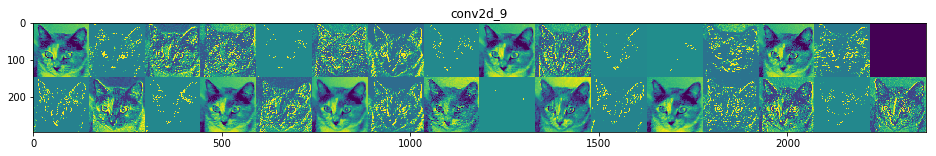

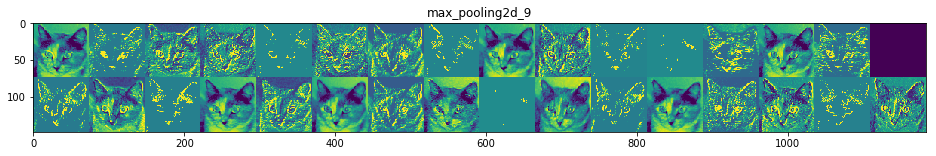

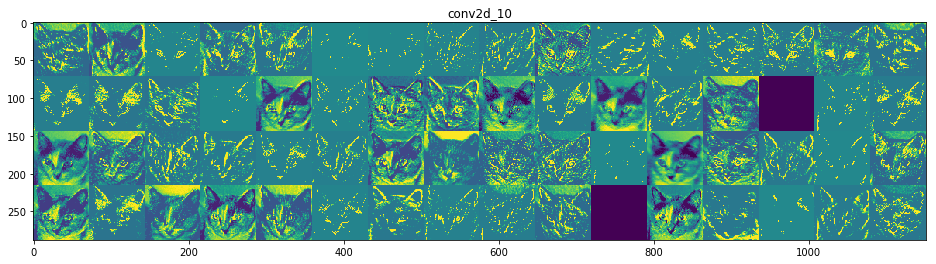

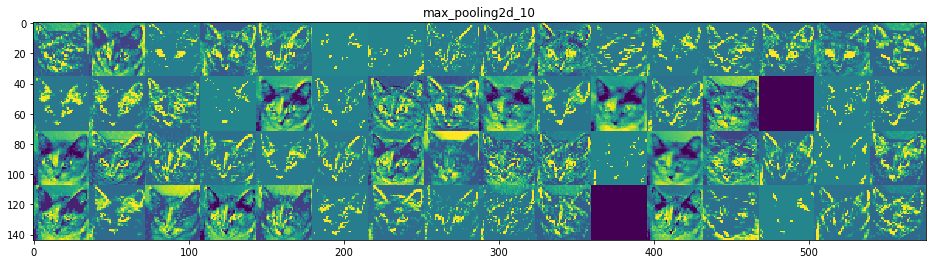

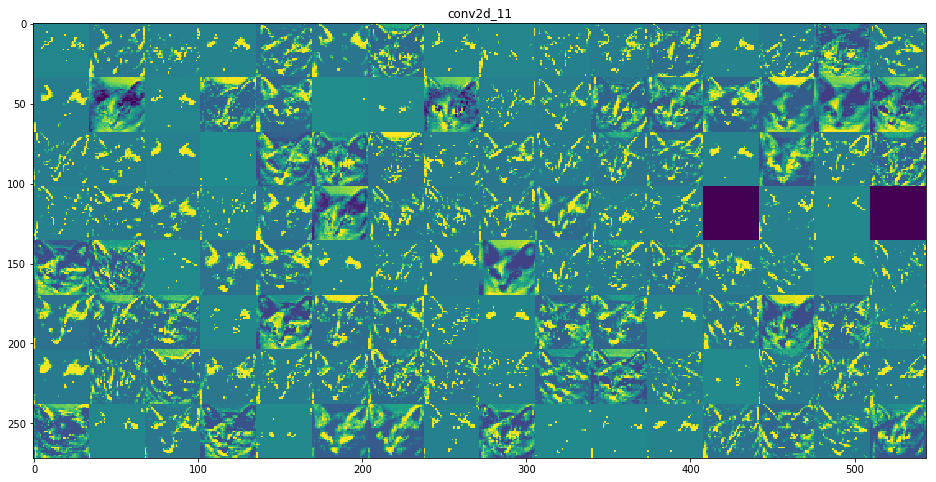

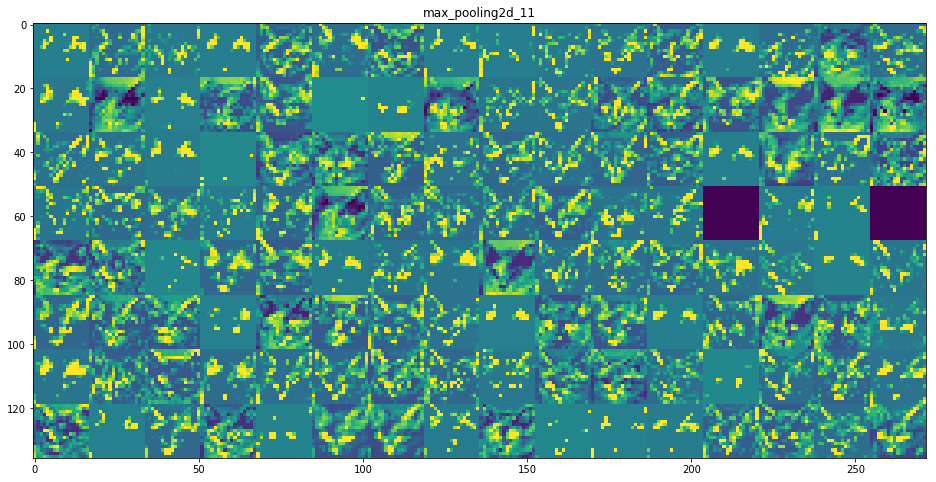

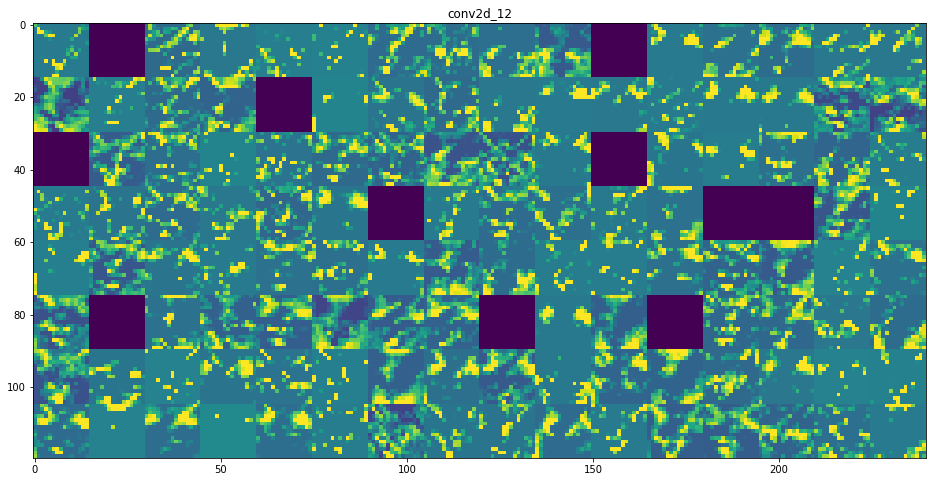

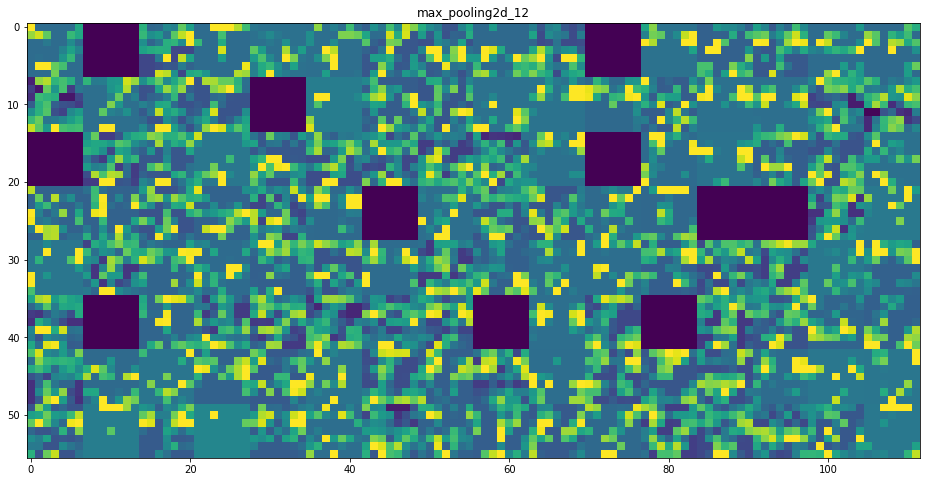

In [8]:
layer_names = []
for layer in model.layers[:8]:
    layer_names.append(layer.name)
    
images_per_row = 16

for layer_name, layer_activation in zip(layer_names, activations):
    n_features = layer_activation.shape[-1]
    
    size = layer_activation.shape[1]
    
    n_cols = n_features // images_per_row
    display_grid = np.zeros((size * n_cols, images_per_row * size))
    
    for col in range(n_cols):
        for row in range(images_per_row):
            channel_image = layer_activation[0,
                                            :, :,
                                            col * images_per_row + row]
            channel_image -= channel_image.mean()
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size,
                        row * size : (row + 1) * size] = channel_image
    
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                       scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')

### Use Gradient ascent in input space to find maximum filter responses (i.e. what filters are looking for)

In [9]:
from keras.applications import VGG16
from keras import backend as K

model = VGG16(weights='imagenet',
             include_top=False)

layer_name = 'block3_conv1'
filter_index = 0

layer_output = model.get_layer(layer_name).output
loss = K.mean(layer_output[:, :, :, filter_index])

In [10]:
model.get_layer(layer_name).output

<tf.Tensor 'block3_conv1/Relu:0' shape=(?, ?, ?, 256) dtype=float32>

In [11]:
K.gradients(loss, model.input)[0]

<tf.Tensor 'gradients/block1_conv1/convolution_grad/Conv2DBackpropInput:0' shape=(?, ?, ?, 3) dtype=float32>

In [12]:
grads = K.gradients(loss, model.input)[0]

In [13]:
grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)

In [14]:
iterate = K.function([model.input], [loss, grads])

import numpy as np
loss_value, grads_value = iterate([np.zeros((1, 150, 150, 3))])

In [15]:
input_img_data = np.random.random((1, 150, 150, 3)) * 20 + 128.

step = 1.
for i in range(40):
    loss_value, grads_value = iterate([input_img_data])
    
    input_img_data += grads_value * step

In [16]:
def deprocess_image(x):
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1
    
    x += 0.5
    x = np.clip(x, 0, 1)
    x *= 255
    x = np.clip(x, 0, 255).astype('uint8')
    return x

In [17]:
def generate_pattern(layer_name, filter_index, size=150):
    layer_output = model.get_layer(layer_name).output
    
    # find the output for a given layer, this is the signal we want to maximize
    loss = K.mean(layer_output[:, :, :, filter_index])
    
    # find the gradient of the output/loss w.r.t. input image
    grads = K.gradients(loss, model.input)[0]
    
    # normalize so we have even update
    grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)
    
    # iterate function we can then perform SGA on
    iterate = K.function([model.input], [loss, grads])
    
    # randomize initial image
    input_img_data = np.random.random((1, size, size, 3)) * 20 + 128.
    
    # step will be also be update weight
    step = 1.
    for i in range(40):
        loss_value, grads_value = iterate([input_img_data])
        input_img_data += grads_value * step
    
    img = input_img_data[0]
    return deprocess_image(img)

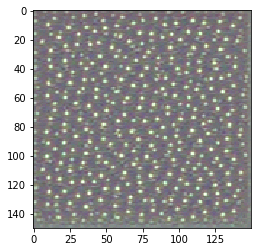

In [18]:
plt.imshow(generate_pattern('block3_conv1', 0))

### Generate Representations for first block filters of all layers

In [19]:
def print_filters(layer_name):
    size = 64
    margin = 5

    # empty results grid
    results = np.zeros((8 * size + 7 * margin, 8 * size + 7 * margin, 3))

    for i in range(8):
        for j in range(8):
            filter_img = generate_pattern(layer_name, i + (j * 8), size=size)

            horizontal_start = i * size + i * margin
            horizontal_end = horizontal_start + size
            vertical_start = j * size + j * margin
            vertical_end = vertical_start + size
            results[horizontal_start: horizontal_end,
                   vertical_start: vertical_end, :] = filter_img
    
    
    plt.figure(figsize=(20, 20))
    plt.title('Max Filter Activations for Layer: {}'.format(layer_name))
    plt.imshow(results)


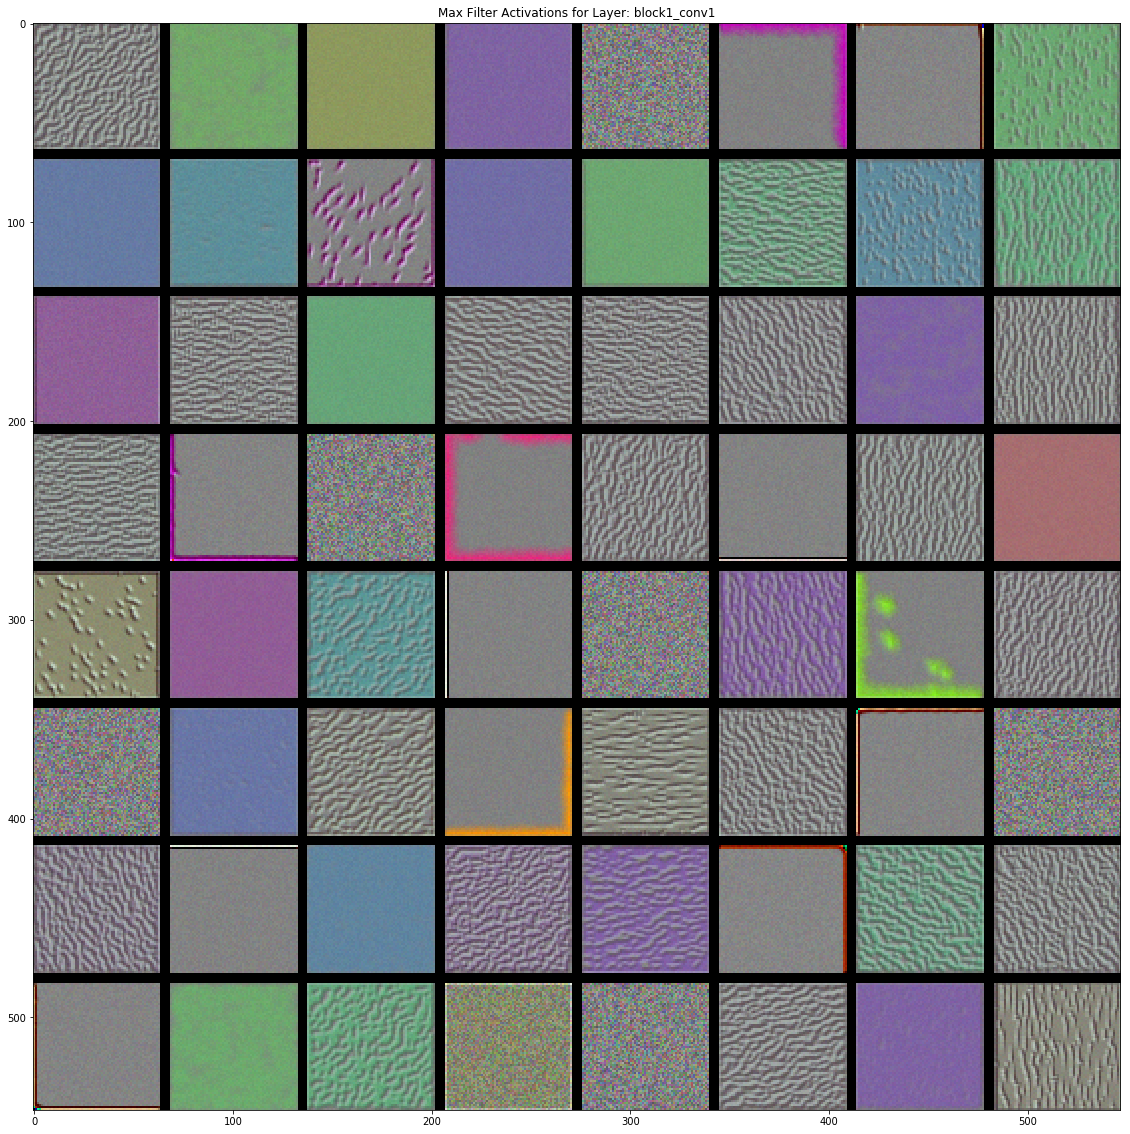

In [20]:
print_filters('block1_conv1')

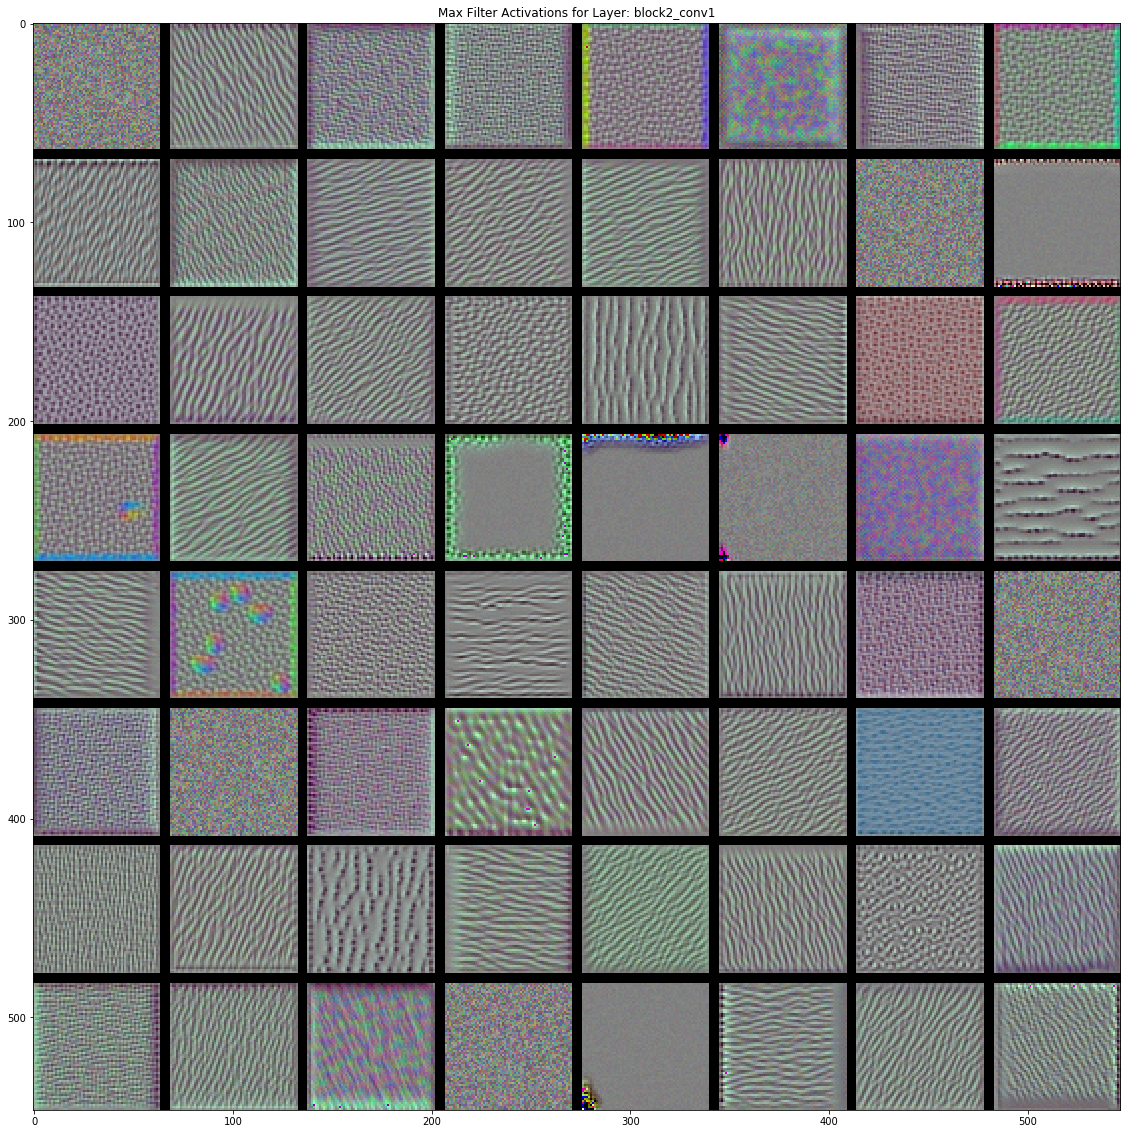

In [21]:
print_filters('block2_conv1')

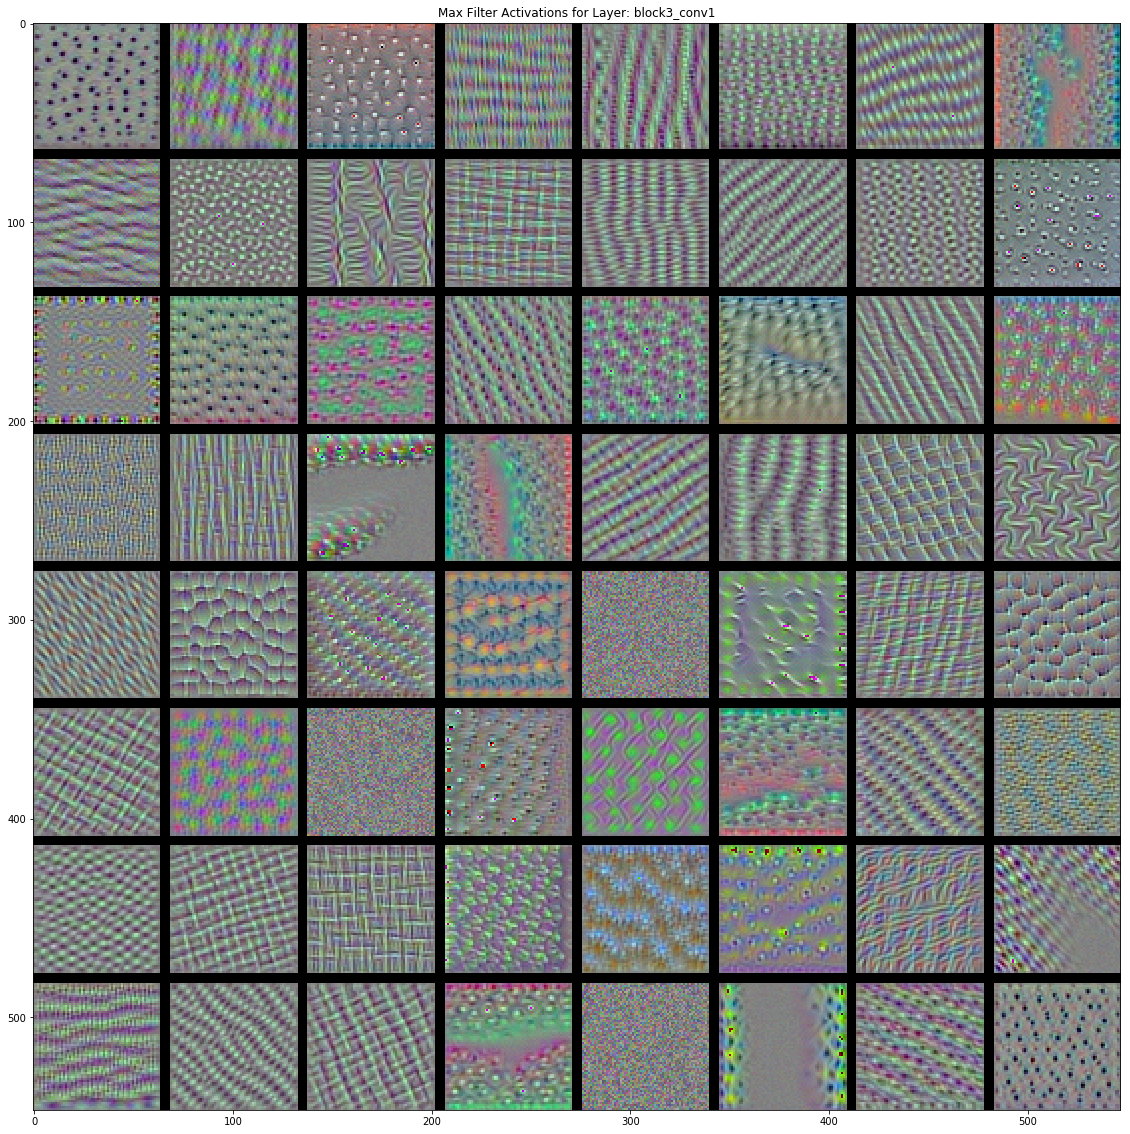

In [22]:
print_filters('block3_conv1')

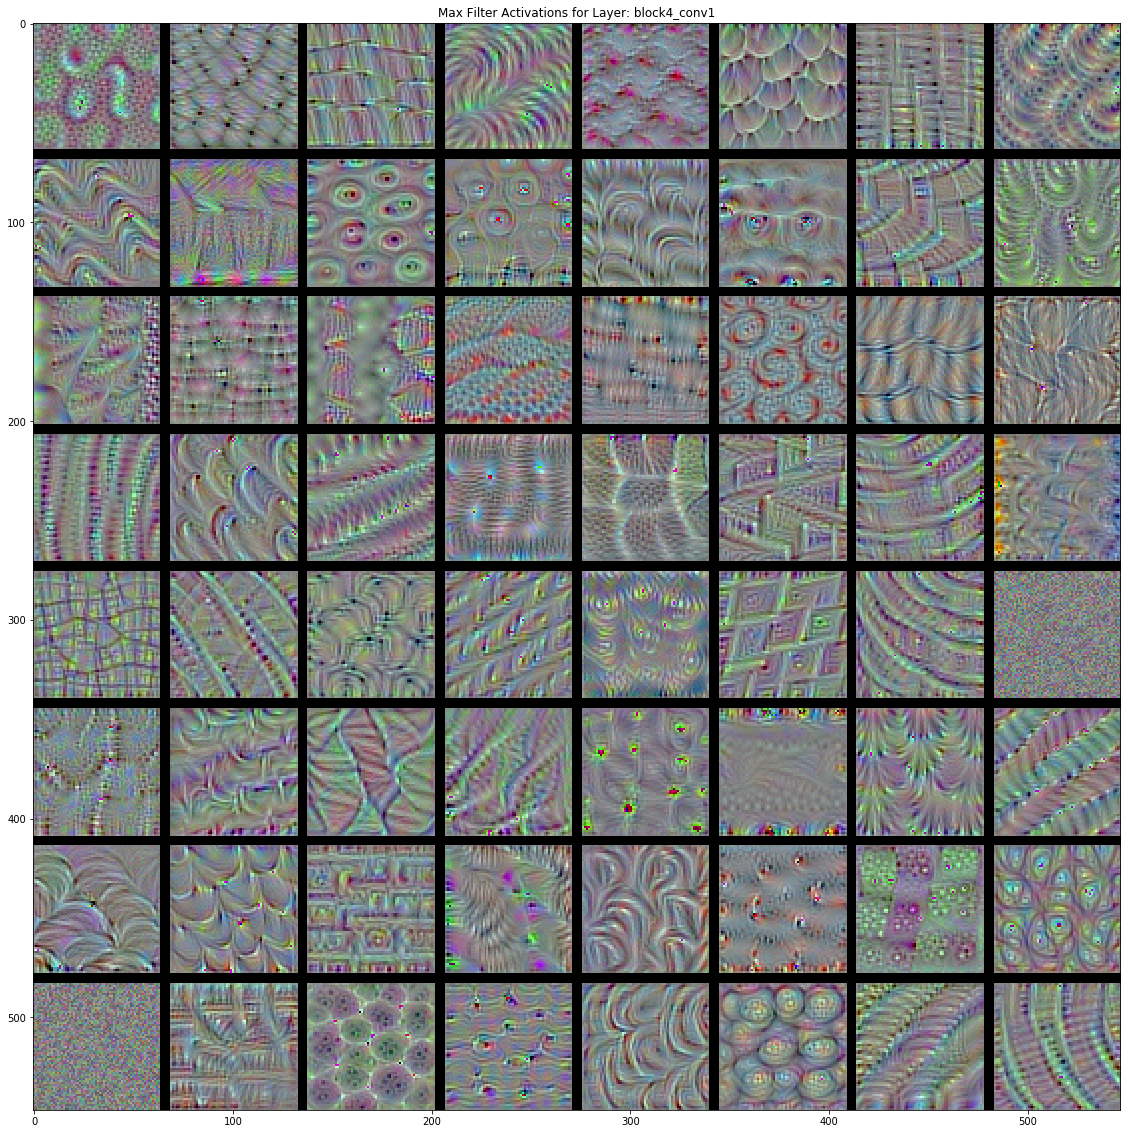

In [23]:
print_filters('block4_conv1')

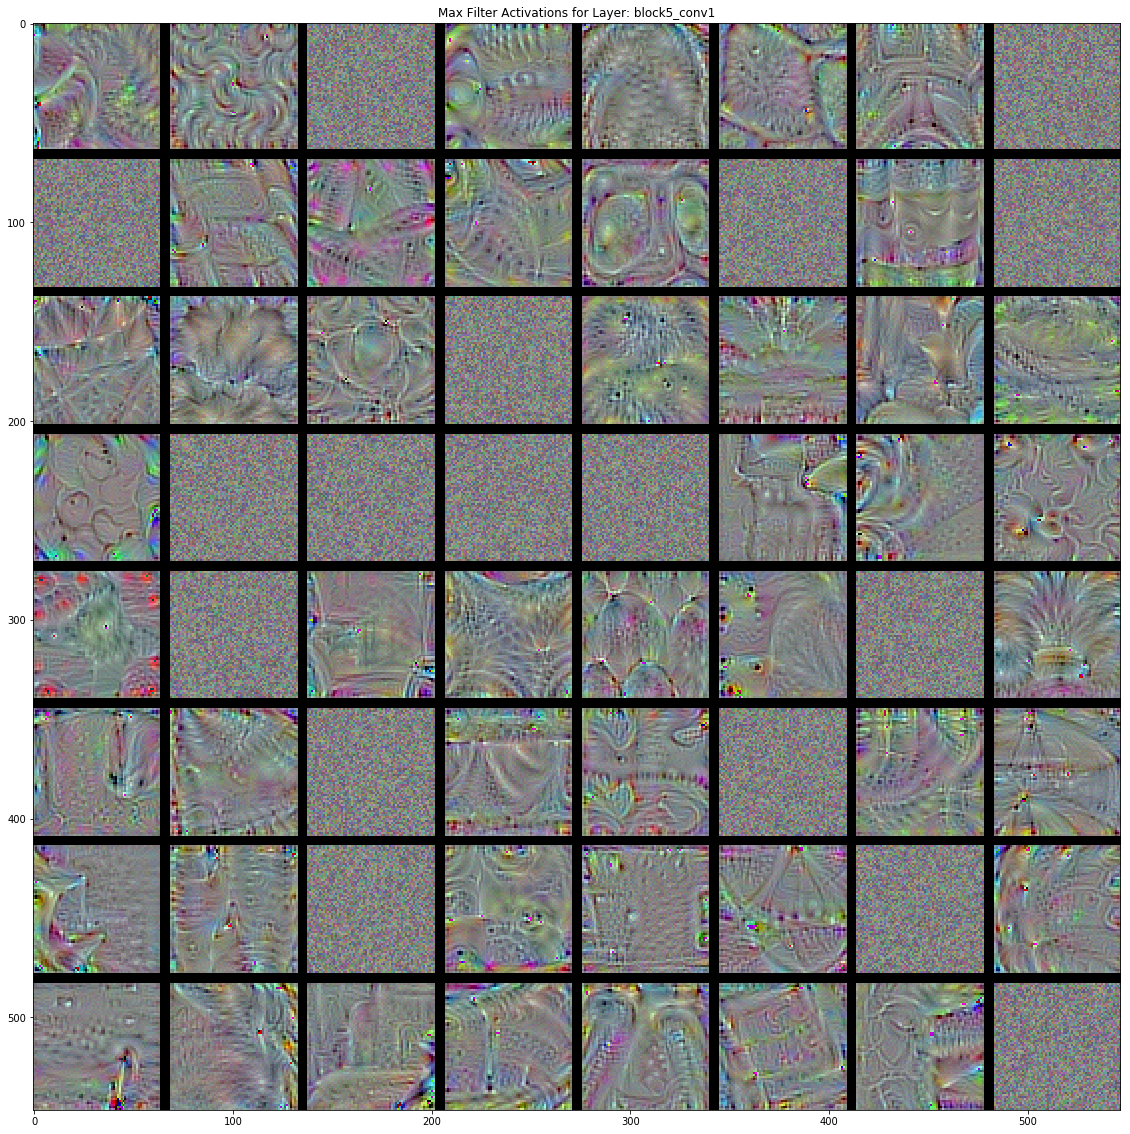

In [24]:
print_filters('block5_conv1')

### Visualizing Heatmaps of Class Activation - Grad-CAM

In [25]:
from keras.applications.vgg16 import VGG16

model = VGG16(weights='imagenet')

In [26]:
#!wget 'http://www.seattleglobalist.com/wp-content/uploads/2016/07/female-elephant-341983_1280.jpg'

In [27]:
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input, decode_predictions

import numpy as np

img_path = './female-elephant-341983_1280.jpg'

img = image.load_img(img_path, target_size=(224, 224))

x = image.img_to_array(img)

# add the (1, :, :) dim
x = np.expand_dims(x, axis=0)

x = preprocess_input(x)

In [28]:
preds = model.predict(x)
print('Predicted:', decode_predictions(preds, top=3)[0])

('Predicted:', [(u'n02504458', u'African_elephant', 0.90942132), (u'n01871265', u'tusker', 0.086182579), (u'n02504013', u'Indian_elephant', 0.0043545761)])


In [29]:
np.argmax(preds[0])

386

In [30]:
african_elephant_output = model.output[:, 386]

last_conv_layer = model.get_layer('block5_conv3')

In [31]:
grads = K.gradients(african_elephant_output, last_conv_layer.output)[0]

In [32]:
pooled_grads = K.mean(grads, axis=(0,1,2))

In [33]:
iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])

pooled_grads_value, conv_layer_output_value = iterate([x])

for i in range(512):
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]

    heatmap = np.mean(conv_layer_output_value, axis=-1)

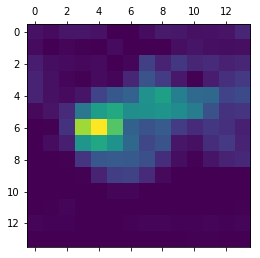

In [34]:
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)
plt.matshow(heatmap)

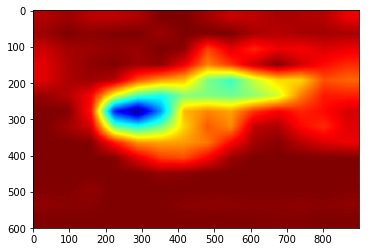

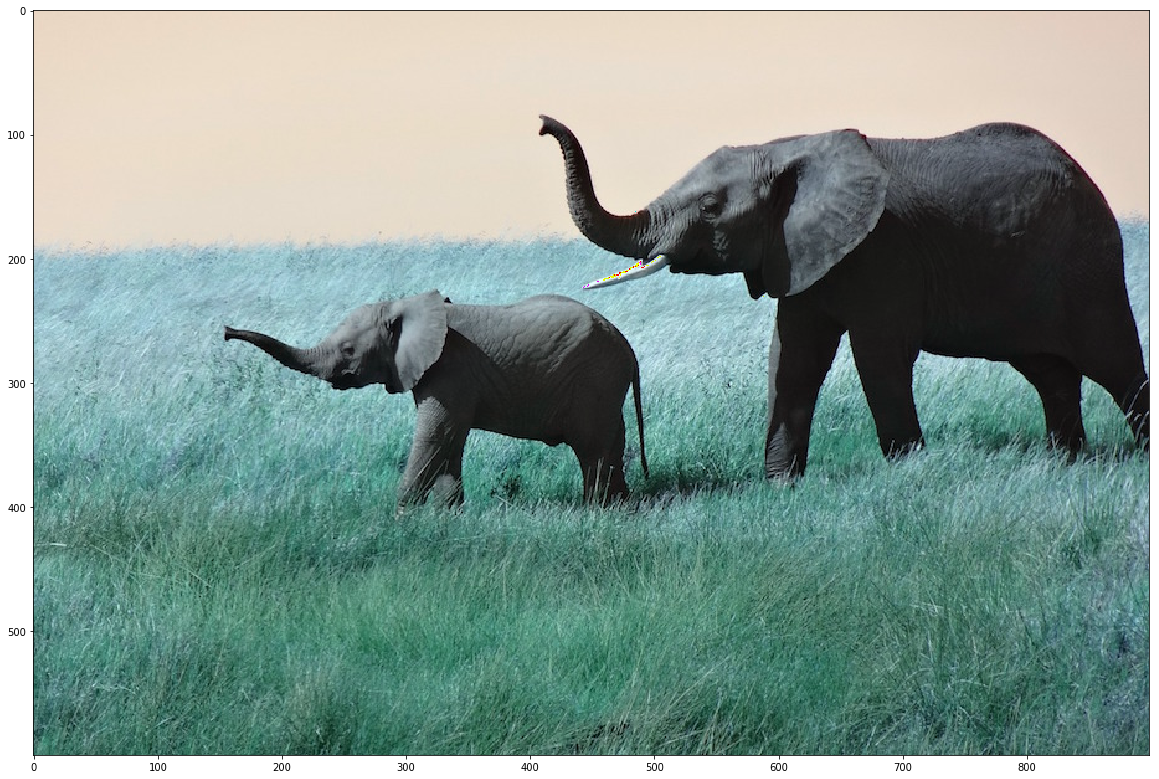

In [35]:
import cv2
import os

img = cv2.imread(img_path)

heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))

heatmap = np.uint8(255*heatmap)

heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
plt.imshow(heatmap.astype('uint8'))
superimposed_img = heatmap * 0.01 + img
#superimposed_img =  img

#os.remove('./elephant_cam.jpg')
cv2.imwrite('./elephant_cam.jpg', superimposed_img)


fig = plt.figure(figsize = (20,20))
plt.imshow(superimposed_img.astype('uint8'))
#plt.title('my picture')
#plt.show()

![elephant](elephant_cam.jpg)